In [4]:
import pandas as pd
import os
import ast
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
from matplotlib import pyplot as plt
import copy
from sklearn.preprocessing import PowerTransformer
import math
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import plotly.graph_objects as go

#### Pass the path of your final CSV file path to `MERGED_CSV_FILE_PATH` that has merged data from 2019, 2020, and 2021. We train one single model for all 3 years combined

In [5]:
MERGED_CSV_FILE_PATH = "YOUR_MERGED_FOLDER_PATH/merged_2019_2020_2021.csv"
combined_dataframe = pd.read_csv(MERGED_CSV_FILE_PATH)
combined_dataframe = combined_dataframe.drop(combined_dataframe.columns[0], axis=1)
combined_dataframe['agbd_points'] = combined_dataframe['agbd_points'].apply(ast.literal_eval)
combined_dataframe['overlap'] = combined_dataframe['overlap'].apply(ast.literal_eval)
list_ = combined_dataframe.values.tolist()

In [6]:
dummies = pd.get_dummies(combined_dataframe.Ecoregion_l3)
combined_dataframe_new = combined_dataframe.join(dummies)

In [7]:
list_ = combined_dataframe_new.values.tolist()

In [8]:
#What overlapping percentage of GEDI pixels should you consider for a modis pixel. Default is >= 0.5
def clean_up_list(l, overlap_percentage=0.5):
  l = l.copy()
  filtered_list = []
  for i in l:
    agbd = i[18]
    overlap = i[23]
    filtered_agbd = [value for value, b_value in zip(agbd, overlap) if b_value >= overlap_percentage]
    i[18] = filtered_agbd.copy()
  return l.copy()

filterd_list = clean_up_list(copy.deepcopy(list_.copy()))

In [9]:
#Plotting cumulative count of number of GEDI pixels per MODIS pixel
agbd_count = {}
for i in filterd_list:
  len_ = len(i[18])
  agbd_count[len_] = agbd_count.get(len_, 0) + 1
print(agbd_count)
cumulative_count = {}
for i in agbd_count:
  cumulative_count[i] = 0
  for j in agbd_count:
    if j >= i:
      cumulative_count[i] = cumulative_count[i] + agbd_count[j]




{3: 21505, 8: 11286, 6: 15843, 7: 13296, 5: 17641, 13: 2981, 9: 9912, 10: 6559, 15: 2065, 11: 4375, 1: 30847, 4: 19699, 2: 24966, 0: 7423, 14: 2632, 17: 1368, 12: 3593, 16: 1675, 21: 488, 18: 1124, 20: 621, 23: 360, 19: 801, 28: 131, 22: 414, 25: 211, 27: 150, 30: 71, 34: 36, 26: 203, 24: 263, 29: 89, 31: 68, 35: 30, 36: 21, 40: 9, 33: 49, 32: 58, 38: 13, 41: 8, 44: 3, 47: 2, 37: 13, 43: 10, 49: 3, 39: 9, 53: 2, 42: 6, 46: 4, 51: 1}


In [10]:

sorted_data = dict(sorted(cumulative_count.items()))

# Extract keys and values for plotting
categories = list(sorted_data.keys())
values = list(sorted_data.values())

# Create bar chart
fig = go.Figure(data=[
    go.Bar(name='Sample Data', x=categories, y=values)
])

# Customize layout
fig.update_layout(
    title='Sorted Bar Chart',
    xaxis_title='Categories',
    yaxis_title='Values',
    barmode='group'
)

# Show the figure
fig.show()

In [15]:
def find_best_features_for_gedi_per_modis_pixel(mean_count):
  filtered_by_region_mean = []
  mean_count = 14

  for index_, row in enumerate(filterd_list):
    agbd_values = row[18]
    if len(agbd_values) >= mean_count:
      if all(value >= 0 for value in agbd_values):
        mean_agbd = sum(agbd_values) / len(agbd_values)
        values_to_add = [row[i] for i in [1,2,3,4,8,9,10,11,12,13,14,15,16,17,19,21,24] + list(range(26, 44))]
        values_to_add.append(math.log(mean_agbd)) #center your target variable with log transformation
        filtered_by_region_mean.append(values_to_add)

  data_array = np.array(filtered_by_region_mean)
  X, y = data_array[:, :-1], data_array[:, -1]
  transformer_dict = {idx: PowerTransformer(method='yeo-johnson') for idx in [0, 1, 2,3,5,6,7,8,9,10,11,12,13,15,16]}
  for idx in transformer_dict:
      X[:, idx] = transformer_dict[idx].fit_transform(X[:, idx].reshape(-1, 1)).flatten()

  Q1 = np.percentile(y, 25)
  Q3 = np.percentile(y, 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  y = np.where((y < lower_bound) | (y > upper_bound), np.nan, y)
  X = X[~np.isnan(y)]
  y= y[~np.isnan(y)]
  scaler = StandardScaler()
  X = scaler.fit_transform(X) #its okay for now to normalize the whole dataset rather than train and test. Its also okay to not normalize here. Best features would still be the same
  return X, y

In [16]:
#DO NOT CHANGE THE ORDER HERE
cols = ['Aqua_gpp_mean_annual', 'Aqua_npp_mean_annual',
       'EVI_mean', 'EVI_mean_annual', 'Fpar_mean', 'Fpar_mean_annual', 'Lai_mean',
       'Lai_mean_annual', 'NDVI_mean', 'NDVI_mean_annual', 'NDWI_mean',
       'NDWI_mean_annual', 'Terra_gpp_mean_annual', 'Terra_npp_mean_annual',
        'aspect', 'elevation', 'slope', '15  Northern Rockies',
       '16  Idaho Batholith', '17  Middle Rockies', '18  Wyoming Basin',
       '19  Wasatch and Uinta Mountains', '20  Colorado Plateaus',
       '21  Southern Rockies', '22  Arizona/New Mexico Plateau',
       '25  High Plains', '26  Southwestern Tablelands',
       '27  Central Great Plains', '41  Canadian Rockies',
       '42  Northwestern Glaciated Plains', '43  Northwestern Great Plains',
       '44  Nebraska Sand Hills', '46  Northern Glaciated Plains',
       '47  Western Corn Belt Plains', '48  Lake Agassiz Plain']

#### We run feature selection and the number of "How many GEDI L4A pixels are worth considering per MODIS pixel?"
#### Manually inspect what the count of GEDI L4A pixels that best represents a MODIS Pixel
#### In our case, we found atleast 14 GEDI pixels are needed to best represents a MODIS Pixel
#### With regard to feature selection, we fix L3 regions as manadatory features (no feature selection will be done on them)
#### While for other features 'Aqua_gpp_mean_annual', 'Aqua_npp_mean_annual', 'EVI_mean', 'EVI_mean_annual', 'Fpar_mean', 'Fpar_mean_annual', 'Lai_mean', 'Lai_mean_annual', 'NDVI_mean', 'NDVI_mean_annual', 'NDWI_mean', 'NDWI_mean_annual', 'Terra_gpp_mean_annual', 'Terra_npp_mean_annual' we do feature selection via Sequential Forward Selection. We add features one-by-one and see which one has the lowest MAE

In [23]:
def ret():
  all_sfs = {}
  for mean_count in range(14, 21):
    lr = RandomForestRegressor(random_state=42)
    X, y = find_best_features_for_gedi_per_modis_pixel(mean_count)
    X_df = pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])])
    sfs = SFS(lr,
              k_features=35,
              forward=True,
              floating=False,
              fixed_features = ([str(i) for i in range(17, 35)]),
              scoring='neg_mean_absolute_error',
              verbose=2,
              n_jobs=-1,
              cv=10)

    sfs_2 = sfs.fit(X_df, y)
    fig = plot_sfs(sfs_2.get_metric_dict(), kind='std_err')

    plt.title(f'Sequential Forward Selection (w. StdErr) for GEDI mean count {mean_count}')
    plt.grid()
    plt.show()
    print(f"Metrics for GEDI mean count {mean_count} {sfs_2.get_metric_dict()}")
    all_sfs[mean_count] = sfs_2.get_metric_dict()
  return all_sfs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:   31.6s remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  15 out of  17 | elapsed:   37.4s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   37.7s finished

[2024-08-12 01:09:29] Features: 19/35 -- score: -0.39955166665176056[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   46.2s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  16 | elapsed:   50.7s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   51.3s finished

[2024-08-12 01:10:20] Features: 20/35 -- score: -0.34686202034363334[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.0min remaining:   54.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished

[2024-08-12 

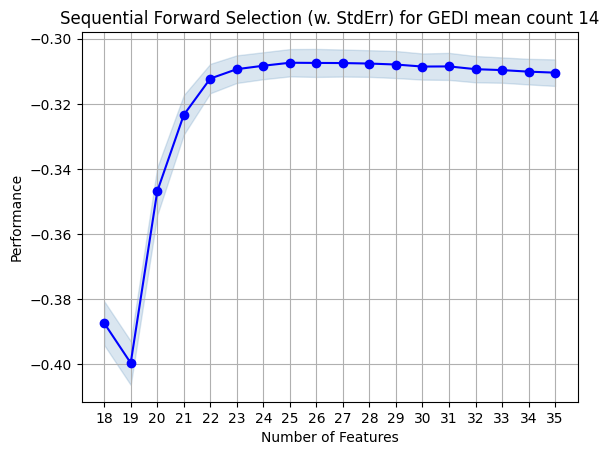

Metrics for GEDI mean count 14 {18: {'feature_idx': (17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34), 'cv_scores': array([-0.35946636, -0.38983685, -0.41675648, -0.39615271, -0.38655371,
       -0.36280051, -0.407911  , -0.37256059, -0.36726075, -0.41380854]), 'avg_score': -0.38731074857016334, 'feature_names': ('17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34'), 'ci_bound': 0.014991621253799868, 'std_dev': 0.02018494660767547, 'std_err': 0.0067283155358918234}, 19: {'feature_idx': (16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34), 'cv_scores': array([-0.35669184, -0.41329712, -0.42339824, -0.4065589 , -0.39059027,
       -0.40718849, -0.41952276, -0.37897155, -0.38426001, -0.41503747]), 'avg_score': -0.39955166665176056, 'feature_names': ('16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34'), 'ci_bound': 0.0149989787529

In [24]:
sfs_linear_with_eco_rf = ret()

In [25]:
sfs_linear_with_eco_rf

{14: {18: {'feature_idx': (17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34),
   'cv_scores': array([-0.35946636, -0.38983685, -0.41675648, -0.39615271, -0.38655371,
          -0.36280051, -0.407911  , -0.37256059, -0.36726075, -0.41380854]),
   'avg_score': -0.38731074857016334,
   'feature_names': ('17',
    '18',
    '19',
    '20',
    '21',
    '22',
    '23',
    '24',
    '25',
    '26',
    '27',
    '28',
    '29',
    '30',
    '31',
    '32',
    '33',
    '34'),
   'ci_bound': 0.014991621253799868,
   'std_dev': 0.02018494660767547,
   'std_err': 0.0067283155358918234},
  19: {'feature_idx': (16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34),
   'cv_scores': array([-0.35669184, -0.41329712, -0.42339824, -0.4065589 , -0.39059027,
          -0.40718849, -0.41952276, -0.37897155, -0.38426001,

#### We found that 7 features EVI_mean, Fpar_mean_annual, NDVI_mean, NDWI_mean, aspect, elevation, slope has the lowest MAE and the lowest feature count (only 7). (Note: L3 regions are always included as features)

In [26]:
BEST_MEAN_COUNT= 14
BEST_FEATURE_COUNT = 7
for i in sfs_linear_with_eco_rf[14][BEST_FEATURE_COUNT + 18]['feature_names']:
  print(cols[int(i)], i)

EVI_mean 2
Fpar_mean_annual 5
NDVI_mean 8
NDWI_mean 10
aspect 14
elevation 15
slope 16
15  Northern Rockies 17
16  Idaho Batholith 18
17  Middle Rockies 19
18  Wyoming Basin 20
19  Wasatch and Uinta Mountains 21
20  Colorado Plateaus 22
21  Southern Rockies 23
22  Arizona/New Mexico Plateau 24
25  High Plains 25
26  Southwestern Tablelands 26
27  Central Great Plains 27
41  Canadian Rockies 28
42  Northwestern Glaciated Plains 29
43  Northwestern Great Plains 30
44  Nebraska Sand Hills 31
46  Northern Glaciated Plains 32
47  Western Corn Belt Plains 33
48  Lake Agassiz Plain 34
